In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (explained_variance_score, mean_absolute_error, mean_squared_error, r2_score)

import pickle

### Loading model and data

In [3]:
## Load model and parameters
model_file = '../data/prediction_model.p'
[column_list, column_type, missing_replacements, label_encoders, one_hot_encoder, selected_models] =pickle.load(open(model_file, 'rb' ))

In [4]:
# load test data from file
data_file = '../data/test_data.csv'
df_test = pd.read_csv(data_file)
# Check contains
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298985 entries, 0 to 298984
Data columns (total 21 columns):
VendorID                 298985 non-null int64
lpep_pickup_datetime     298985 non-null object
Lpep_dropoff_datetime    298985 non-null object
Store_and_fwd_flag       298985 non-null object
RateCodeID               298985 non-null int64
Pickup_longitude         298985 non-null float64
Pickup_latitude          298985 non-null float64
Dropoff_longitude        298985 non-null float64
Dropoff_latitude         298985 non-null float64
Passenger_count          298985 non-null int64
Trip_distance            298985 non-null float64
Fare_amount              298985 non-null float64
Extra                    298985 non-null float64
MTA_tax                  298985 non-null float64
Tip_amount               298985 non-null float64
Tolls_amount             298985 non-null float64
Ehail_fee                0 non-null float64
improvement_surcharge    298985 non-null float64
Total_amount         

### Data preprocessing

In [5]:
## Keep only positive Total Payment Amount. The model was built with positive Total Payments
df_test = df_test[df_test.Total_amount > 0]

In [6]:
## Keep only credit card transactions. Tip was recorded for only these transactions
df_test = df_test[df_test.Payment_type == 1]

In [7]:
## size of test data
df_test.shape

(140316, 21)

In [8]:
## Define tip_percent function and add a new field for it
df_test["Tip_percent"] = df_test.apply(lambda r: r["Tip_amount"]*100/r["Total_amount"], axis =1)

In [9]:
## Functions to preprocess the test data before prediction
#  - imputes the missing values 
#  - plots/summarizas the datasret
#  - converts categorical data through one hot encoding
#  The prediction file from training contains missing value replacements, encoders, etc


def process_test_column(dx, ctype, replacement):
    missing_loc = dx.isnull()
    print('Number of Records: ', len(dx.index))
    print('Missing Records: ', sum(missing_loc))
    
    if ctype =='categorical':
        print(dx.value_counts())
    elif ctype == 'numeric':
        sns.violinplot(dx)
        plt.show()
    else:
        raise NameError('type not found!')      
    dx = dx.fillna(replacement)    
    return dx


def process_test_data(df, types, replacements, encoders, hot_encoder):
    for x in list(df):
        print('*'*80)
        print(x)
        print('')
        s = process_test_column(df[x], types[x], replacements[x] )
        df[x] = s
    
    for x,le in encoders.items():
        print(x)
        df[x] = le.transform(df[x])

    data_array = hot_encoder.transform(df.values).toarray()
    return data_array
    

********************************************************************************
RateCodeID

Number of Records:  140316
Missing Records:  0
1     137437
5       2322
2        366
4         97
3         93
99         1
Name: RateCodeID, dtype: int64
********************************************************************************
Passenger_count

Number of Records:  140316


C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Missing Records:  0
1    118178
2     10602
5      5344
3      3138
6      2182
4       833
0        36
7         2
8         1
Name: Passenger_count, dtype: int64
********************************************************************************
Trip_distance

Number of Records:  140316
Missing Records:  0


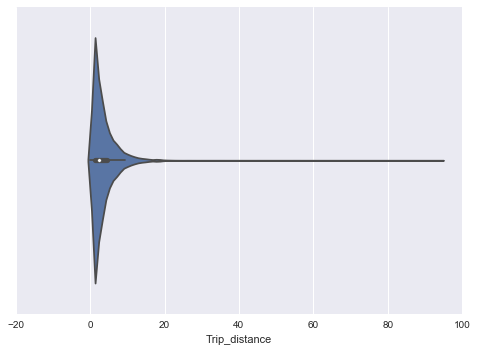

********************************************************************************
Fare_amount

Number of Records:  140316
Missing Records:  0


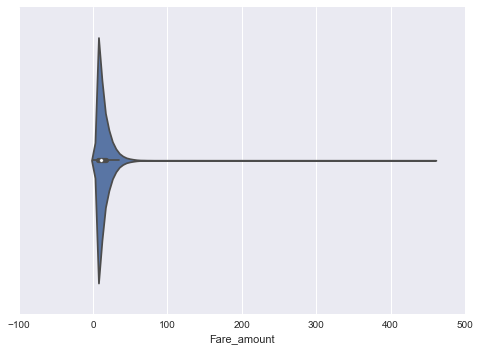

********************************************************************************
Extra

Number of Records:  140316
Missing Records:  0


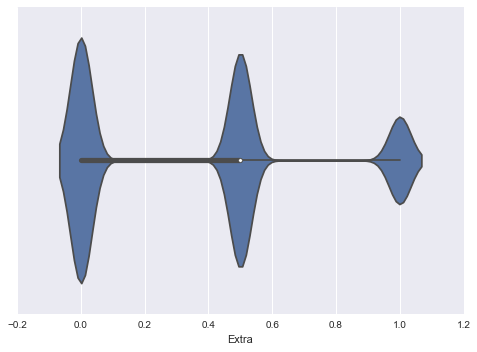

********************************************************************************
MTA_tax

Number of Records:  140316
Missing Records:  0


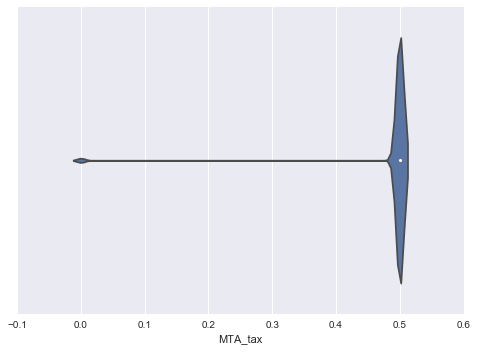

********************************************************************************
Tolls_amount

Number of Records:  140316
Missing Records:  0


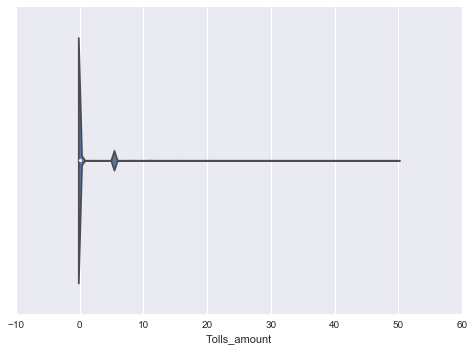

********************************************************************************
improvement_surcharge

Number of Records:  140316
Missing Records:  0


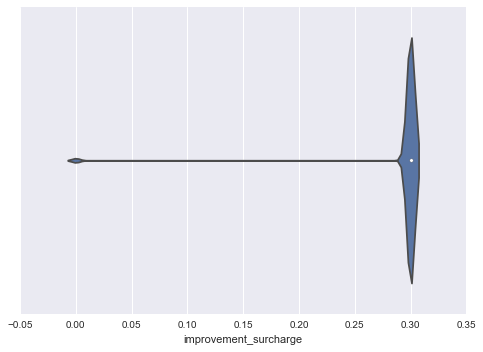

********************************************************************************
Total_amount

Number of Records:  140316
Missing Records:  0


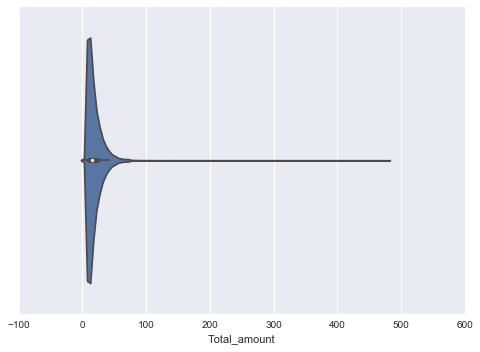

********************************************************************************
Trip_type 

Number of Records:  140316
Missing Records:  1
1.0    138030
2.0      2285
Name: Trip_type , dtype: int64
Passenger_count
RateCodeID
Trip_type 


C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
## Preprocess the test data before prediction
test_data_array = process_test_data(df_test[column_list], column_type, missing_replacements, label_encoders, one_hot_encoder)

In [11]:
# Size of converted test data
test_data_array.shape

(140316, 25)

### Prediction

In [12]:
### Predict the Tip_percent
#   the predition file contains the model (in this case one)
test_data_prediction = pd.DataFrame()
for model_name, model in selected_models.items():
    test_data_prediction[model_name] = model.predict(test_data_array)

In [13]:
## Define true and precdiction lists for various accracy calculations 
##
y_true = list(df_test["Tip_percent"].values)
y_pred = list(test_data_prediction["RandomForestRegressor"].values)

### Accuracy metrics

In [14]:
## R² score, the coefficient of determination
print(r2_score(y_true, y_pred))

0.996946058368


In [15]:
## Explained variance score
print(explained_variance_score(y_true, y_pred))

0.996946107629


In [16]:
## Mean squared error¶
print(mean_squared_error(y_true, y_pred))

0.186537844966


In [17]:
## Mean absolute error
print(mean_absolute_error(y_true, y_pred))

0.0373198709955


### Plotting the boxplot of errors

In [18]:
diff = [x-y for x,y in zip(y_true,y_pred)]

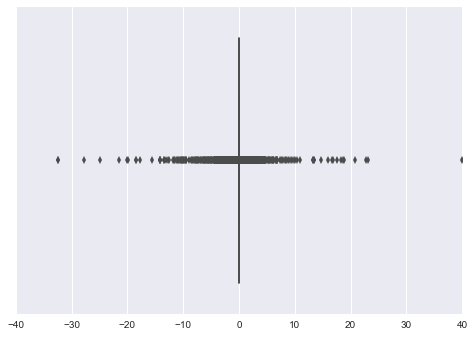

In [19]:
## See error boxplot 
sns.boxplot(diff)

In [ ]:
#